<a href="https://colab.research.google.com/github/marcinwolter/MCtuning/blob/master/MC_tuning_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate some data

In [ ]:
import numpy as np

n_dim = 2



Generator

In [ ]:
def generator(batch_size, par_0, par_fit):

  X_batch  = np.zeros((batch_size, n_dim))
  y_batch  = np.zeros((batch_size, 1))

  event = np.zeros( n_dim)

  while True:
   for n in range(batch_size):
    if np.random.randint(0,2):
      for k in range(n_dim):
        X_batch[n,k] = np.random.normal(loc=par_0[0+2*k], scale=par_0[1+2*k], size=None)
      y_batch[n,0] = 0
    else:
      for k in range(n_dim):
        X_batch[n,k] = np.random.normal(loc=par_fit[0+2*k], scale=par_fit[1+2*k], size=None)
      y_batch[n,0] = 1       


   #print(X_batch,y_batch)
    
   yield X_batch, y_batch



Deep neural network

In [ ]:

def model_nn():
  from keras.datasets import mnist
  from keras.models import Sequential
  from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
  from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
  from keras.utils import np_utils


  model = Sequential()
  model.add(Dense(48, activation='relu', input_dim=n_dim))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:

from hyperopt import fmin, tpe, hp
from hyperopt import Trials

model = model_nn()

# number of hyperopt iterations
nIter = 500
 

def f_nn(space):
    p = np.zeros(4)
    p[0] = space['p0']
    p[1] = space['p1']
    p[2] = space['p2']
    p[3] = space['p3']
    


    #Train the model using generator vs using the full batch
    batch_size = 32
    # True values of parameters
    par_0   = np.array([1.,2.,1.,2.])
   
    #print("Training for: ",p)
    cnn = model.fit_generator(
       generator(batch_size,par_0,p),
       epochs=3,
       steps_per_epoch = 100,
       validation_data = generator(batch_size,par_0,p),
       validation_steps = 2,
       verbose=0
    )

    scores_train = model.evaluate_generator(generator(batch_size, par_0, p), steps=100, verbose=0)
    #print("Accuracy ",scores_train[1])
    return scores_train[1]
	
space = {
    'p0': hp.uniform('p0', 0, 2),
    'p1': hp.uniform('p1', 0.1, 3),
    'p2': hp.uniform('p2', 0, 2),
    'p3': hp.uniform('p3', 0.1, 3),
}

trials = Trials()

best = fmin(
    fn=f_nn,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=nIter,
    verbose=1
)


Using TensorFlow backend.


Training for: 
[1.3714828  1.81425954 0.91416539 2.00884595]
Accuracy 
0.5249999761581421
Training for: 
[0.87781227 1.2117534  0.65060708 1.68599987]
Accuracy 
0.6215624809265137
Training for: 
[1.89412753 0.86786695 1.96767822 0.38076417]
Accuracy 
0.8931249976158142
Training for: 
[1.31570643 1.11614499 0.2315235  0.36309025]
Accuracy 
0.8518750071525574
Training for: 
[1.43563834 1.88130089 1.42570406 1.24261614]
Accuracy 
0.6190624833106995
Training for: 
[1.28220318 1.64670602 0.41652547 1.67439776]
Accuracy 
0.5856249928474426
Training for: 
[1.17413473 1.3648101  1.75798356 0.29106707]
Accuracy 
0.8631250262260437
Training for: 
[0.72001888 0.68968147 0.87000094 0.20061156]
Accuracy 
0.9290624856948853
Training for: 
[1.12819783 2.01915007 0.72233725 0.71505291]
Accuracy 
0.7246875166893005
Training for: 
[0.07716504 1.53046358 1.4527962  1.59501928]
Accuracy 
0.6312500238418579
Training for: 
[0.2678804  2.60029266 1.74759752 2.53009312]
Accuracy 
0.6196874976158142
Training f

In [ ]:

print("Found minimum after 100 trials:")
print(best)


#print("Here are the space and results of the 3 first trials (out of a total of 1000):")
#print(trials.trials[0])
#print(trials.trials[1])
#print(trials.trials[2])


#print("What interests us most is the 'result' key of each trial (here, we show 3):")
#print(trials.trials[0]["result"]['loss'])
#print(trials.trials[1]["result"]['loss'])
#print(trials.trials[2]["result"]['loss'])


result = np.zeros(np.size(trials))
for i in range (np.size(result)):
    result[i]=trials.trials[i]["result"]['loss']
#print(trials.trials["result"])
minval = min(result) 
minindex = np.argmin(result)

print("Minimum found :",minval," for parameters: ",trials.trials[minindex]["misc"]["vals"])




Found minimum after 100 trials:
{'p0': 0.9495740095801934, 'p1': 2.0428779159785697, 'p2': 0.9510520400603447, 'p3': 2.0054116255926613}
Minimum found : 0.49656251072883606  for parameters:  {'p0': [0.9495740095801934], 'p1': [2.0428779159785697], 'p2': [0.9510520400603447], 'p3': [2.0054116255926613]}


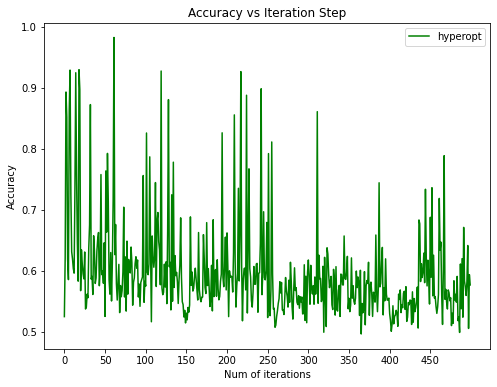

In [ ]:
# Plots for hyperopt optimization
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)

plt.figure(0)

plt.plot(result,'g')
plt.xticks(np.arange(0, len(result), 50.0))
plt.xlabel("Num of iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration Step")
plt.legend(['hyperopt'])
plt.show()



In [ ]:

#Train the model using generator vs using the full batch
batch_size = 32
par_0   = np.array([1.,2.,1.,2.])

par_fit = np.array([trials.trials[minindex]["misc"]["vals"]['p0'], 
                    trials.trials[minindex]["misc"]["vals"]['p1'],
                    trials.trials[minindex]["misc"]["vals"]['p2'],
                    trials.trials[minindex]["misc"]["vals"]['p3'],
                    ])

model = model_nn()

cnn = model.fit_generator(
    generator(batch_size,par_0,par_fit),
    epochs=50,
    steps_per_epoch = 100,
    validation_data = generator(batch_size,par_0,par_fit),
    validation_steps = 20   
)



Epoch 1/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6955 - accuracy: 0.4909 - val_loss: 0.6959 - val_accuracy: 0.4891
Epoch 2/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6936 - accuracy: 0.5022 - val_loss: 0.6943 - val_accuracy: 0.4844
Epoch 3/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6947 - val_accuracy: 0.5078
Epoch 4/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6927 - accuracy: 0.5069 - val_loss: 0.6898 - val_accuracy: 0.4812
Epoch 5/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6937 - accuracy: 0.4956 - val_loss: 0.6857 - val_accuracy: 0.5188
Epoch 6/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6939 - accuracy: 0.5016 - val_loss: 0.6939 - val_accuracy: 0.4938
Epoch 7/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6937 - accuracy: 0.5094 - val_loss: 0.6952 - val_accuracy: 0.4922
Epoch 

In [ ]:
# evaluate loaded model
scores_train = model.evaluate_generator(generator(batch_size, par_0, par_fit), steps=100, verbose=0)
print("Accuracy Validation: %.2f%% " % (scores_train[1]*100))
#scores_test  = model.evaluate_generator(generator(batch_size, par_0, par_fit), steps=100, verbose=0)
#scores_val   = model.evaluate_generator(generator(batch_size, par_0, par_fit), steps=100, verbose=0)
#print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

Accuracy Validation: 50.94% 


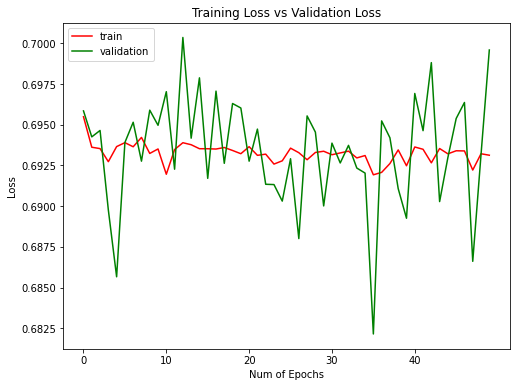

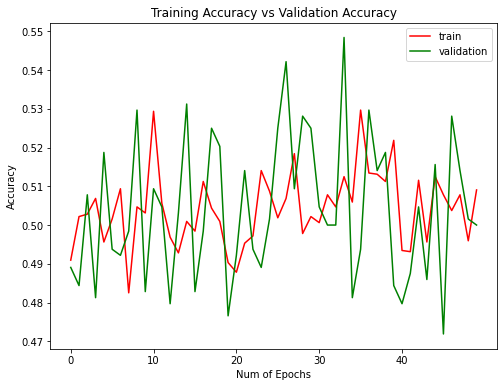

In [ ]:
# Plots for training and testing process: loss and accuracy
import matplotlib.pyplot as plt


n_epochs = len(cnn.history['loss'])

plt.rcParams['figure.figsize'] = (8, 6)

plt.figure(0)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

plt.figure(1)
plt.plot(cnn.history['accuracy'],'r')
plt.plot(cnn.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()